# Employment Scam Aegean Dataset

In [1]:
import library as lib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
sns.set(style='ticks', palette='RdYlGn', font_scale=1.7, rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("./fake_job_postings.csv",index_col='job_id')

In [3]:
dflegit = df[df['fraudulent']==0]
dffraud = df[df['fraudulent']==1]

# Missing values

In [4]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

,Legit_HasValue,Legit_IsNA,Fraud_HasValue,Fraud_IsNA
Columns,,,,
title,100.0,0.0,100.0,0.0
location,98.1,1.9,97.8,2.2
department,35.3,64.7,38.7,61.3
salary_range,15.5,84.5,25.8,74.2
company_profile,84.0,16.0,32.2,67.8
description,100.0,0.0,99.9,0.1
requirements,85.1,14.9,82.2,17.8
benefits,59.8,40.2,58.0,42.0
telecommuting,100.0,0.0,100.0,0.0


## Insights
This dataset contains 17880 jobs and a maximum of 16 characteristics are given to each jobs.
All jobs entry have manually been assigned a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers being flagged as legitimate whilst 866 have been flagged as fraudulent.
_Note:This assignment was done manually and errors might have occured._

As the table above shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes down to company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a positions as Office manager in Warsaw, PL.

17014


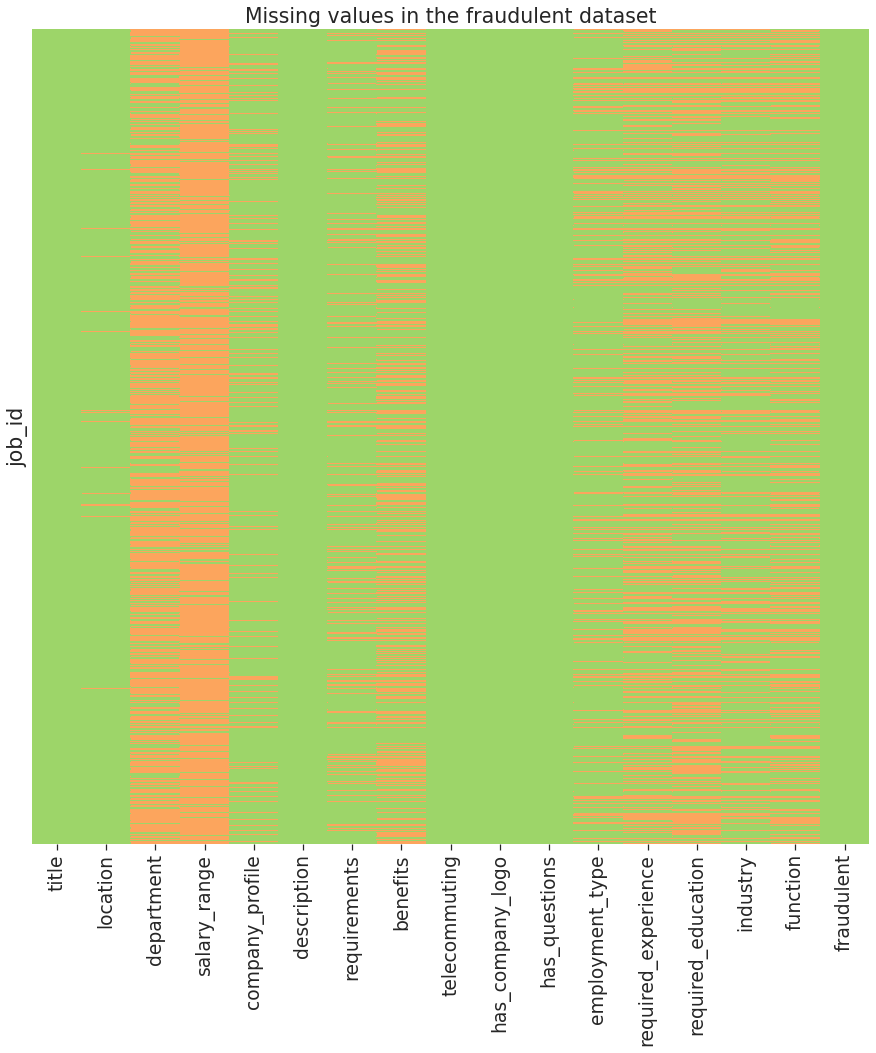

In [5]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


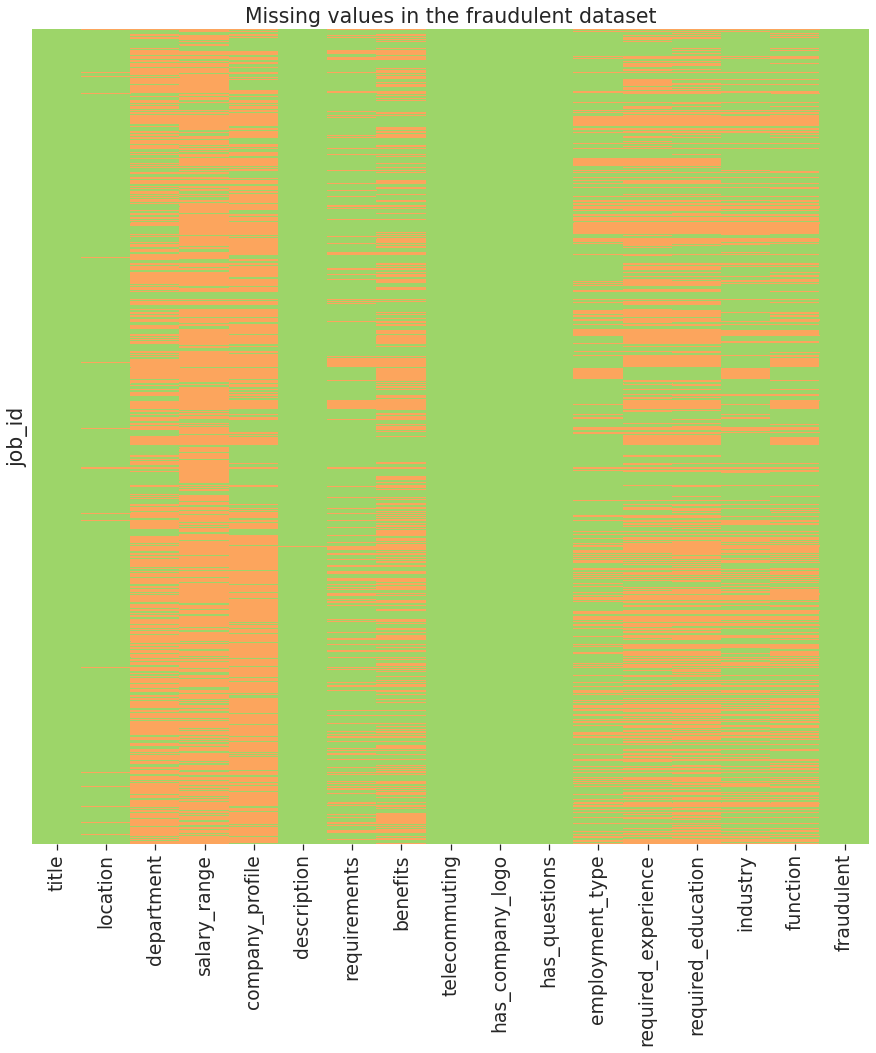

In [6]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

# Text fields

It seems like the fraudsters are struggling with the company profiles... Let's look at text fields in general to see how creative the fraudsters are.

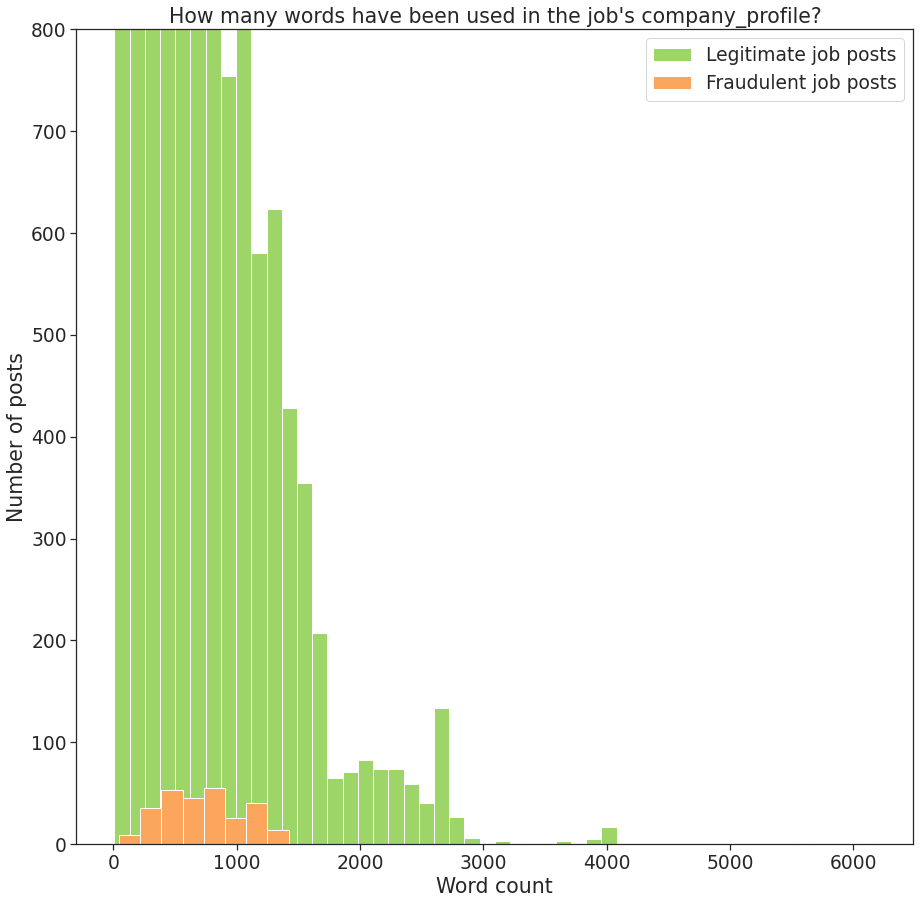

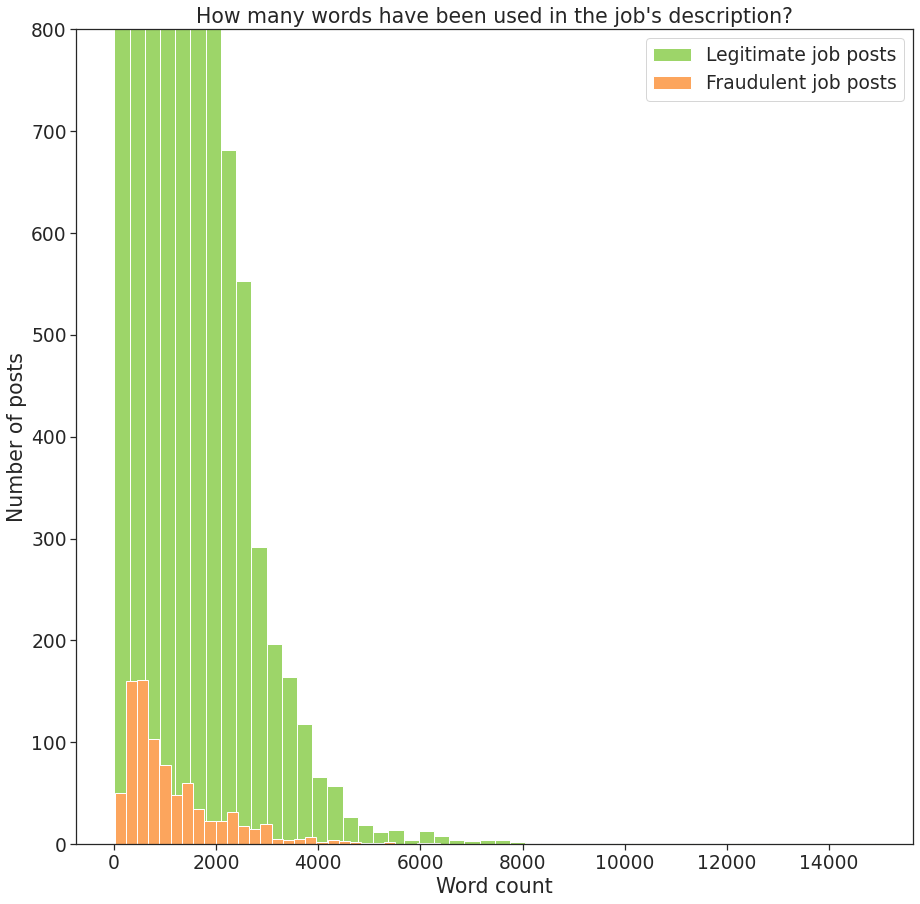

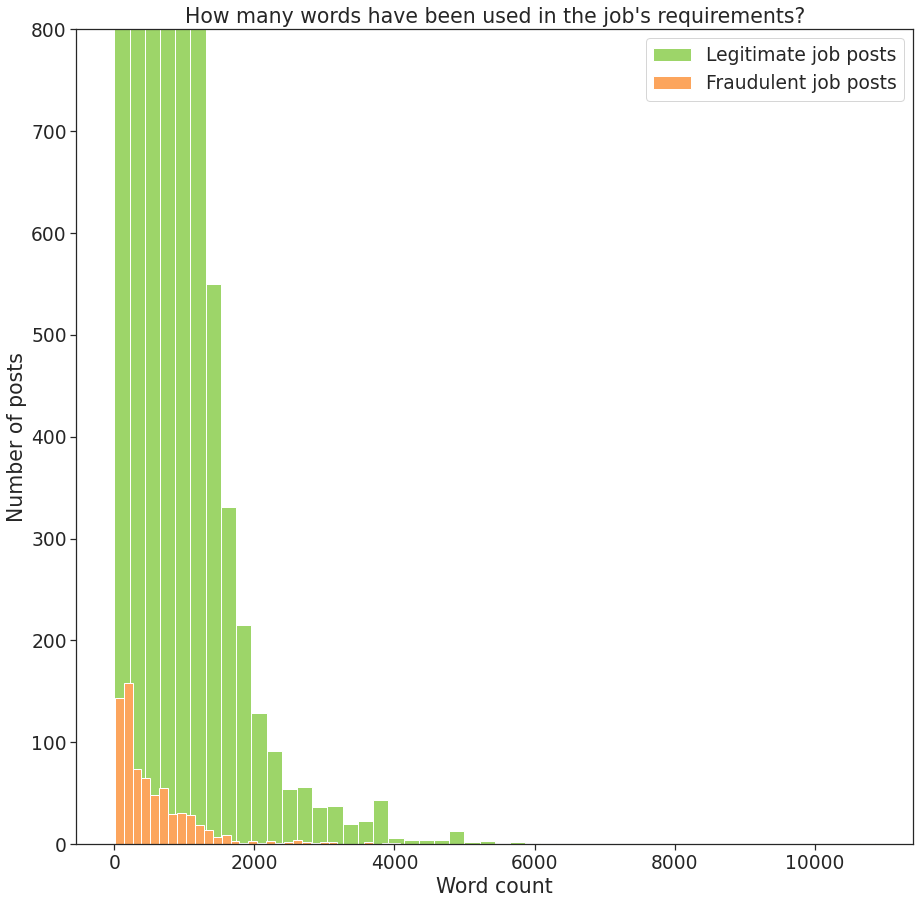

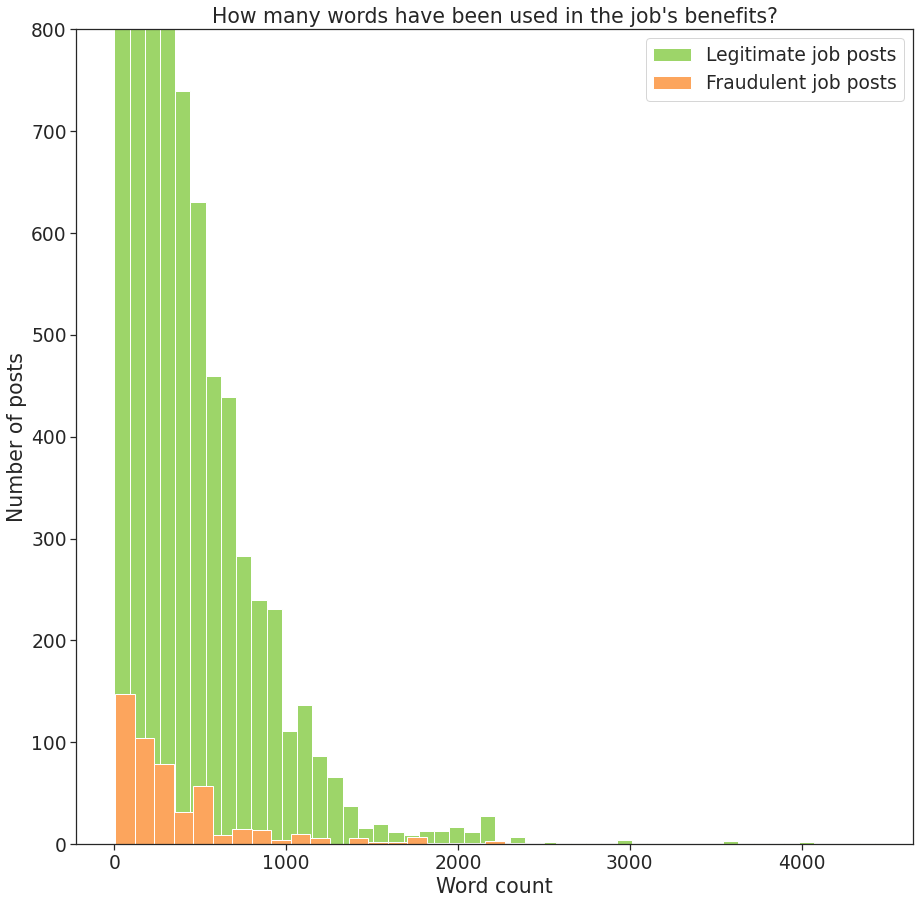

In [7]:
lib.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but even when there is information, the fraudulent job posts are less loquatious than legitimate job posts. Especially for job requirements and company_profile.

# Categorical information

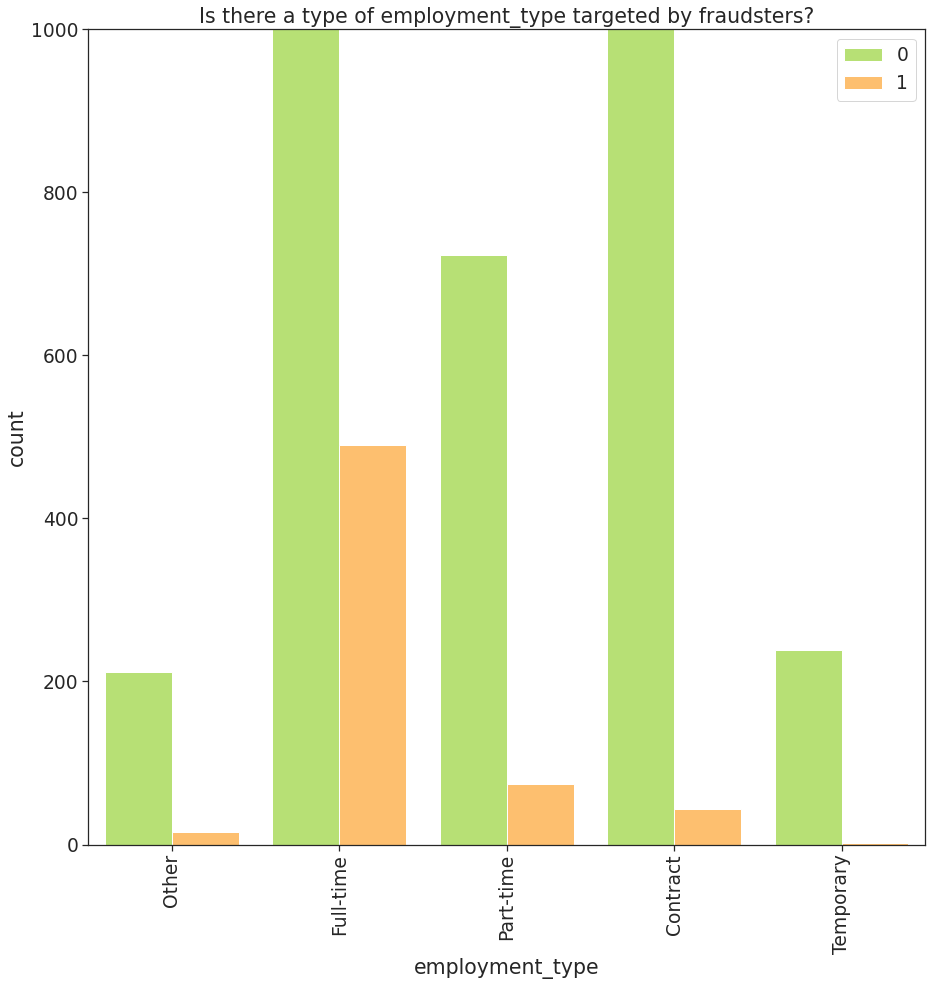

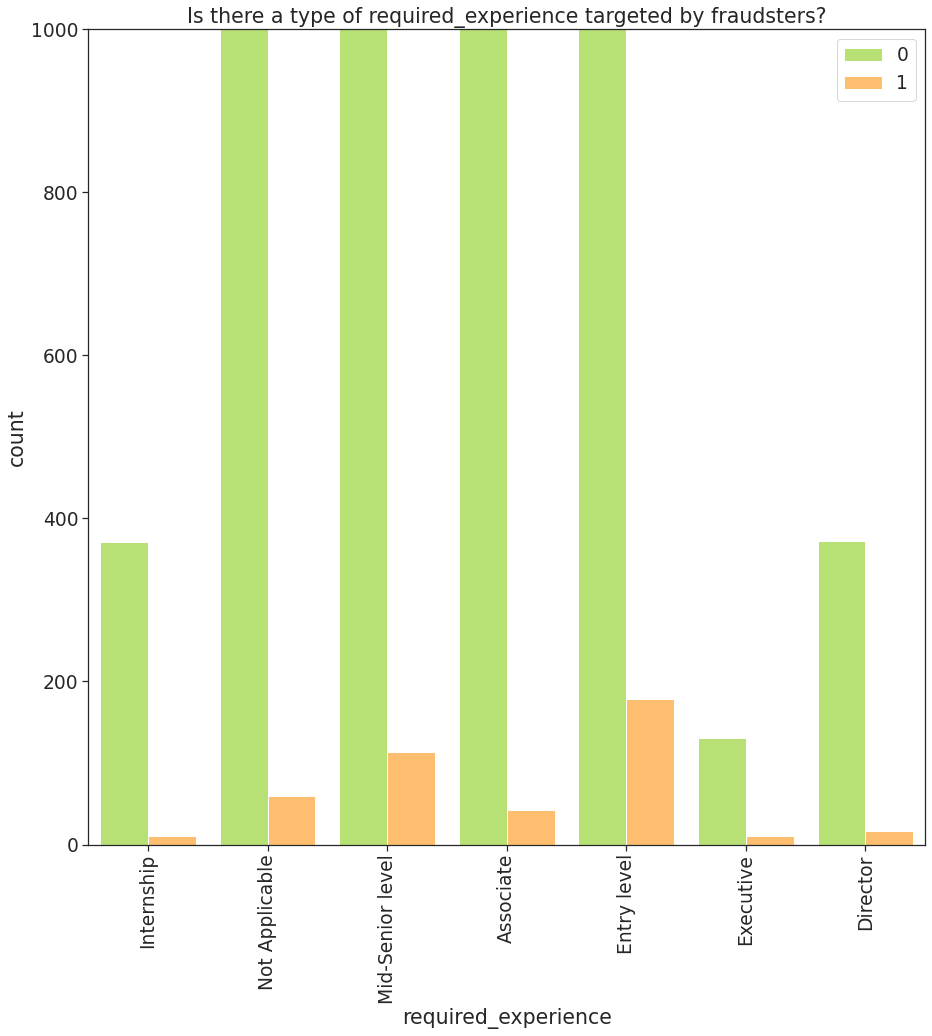

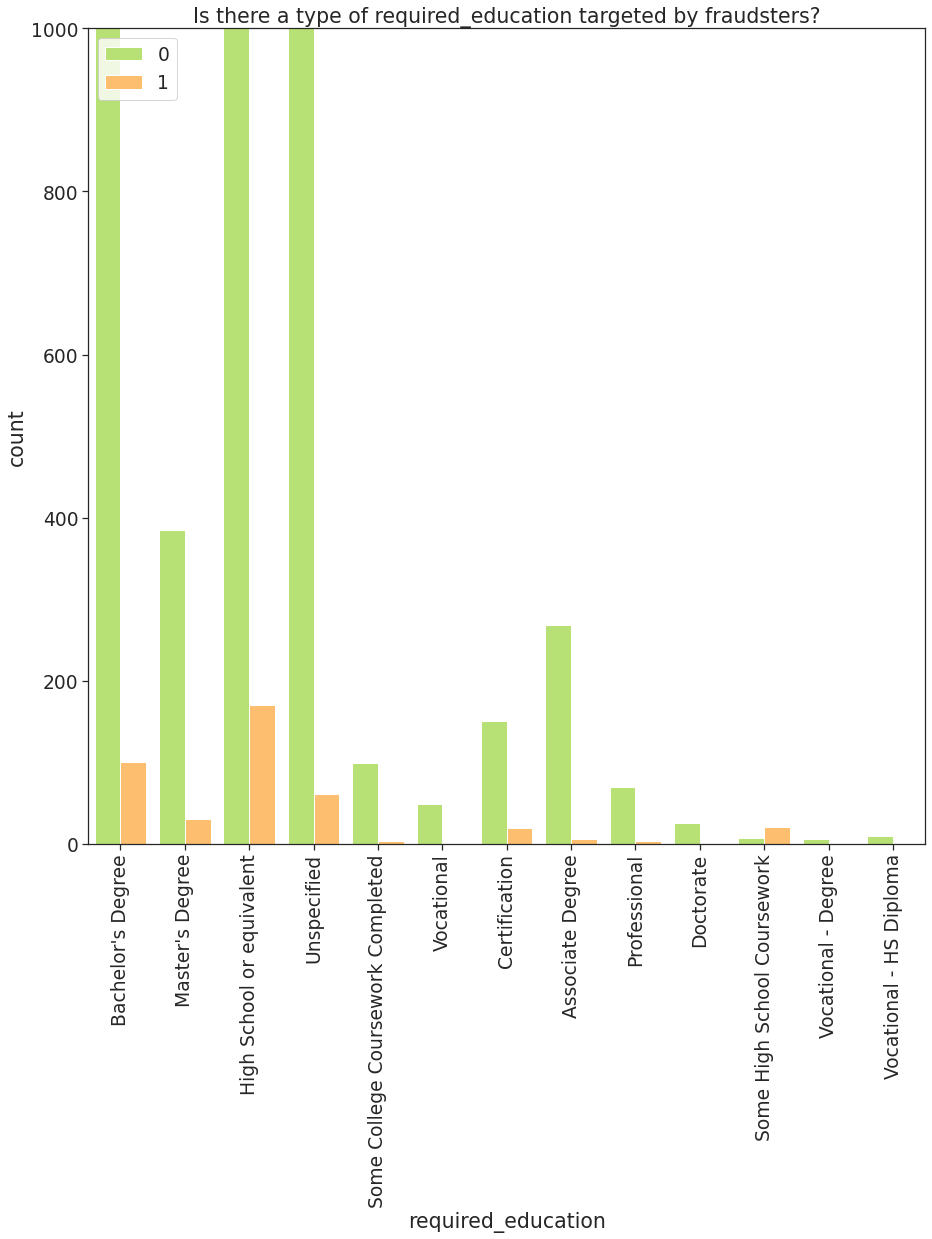

In [8]:
lib.count_plot(df,11,14)

# Extracting extra information

Some job offers have phone, email and/or external url information:

In [9]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

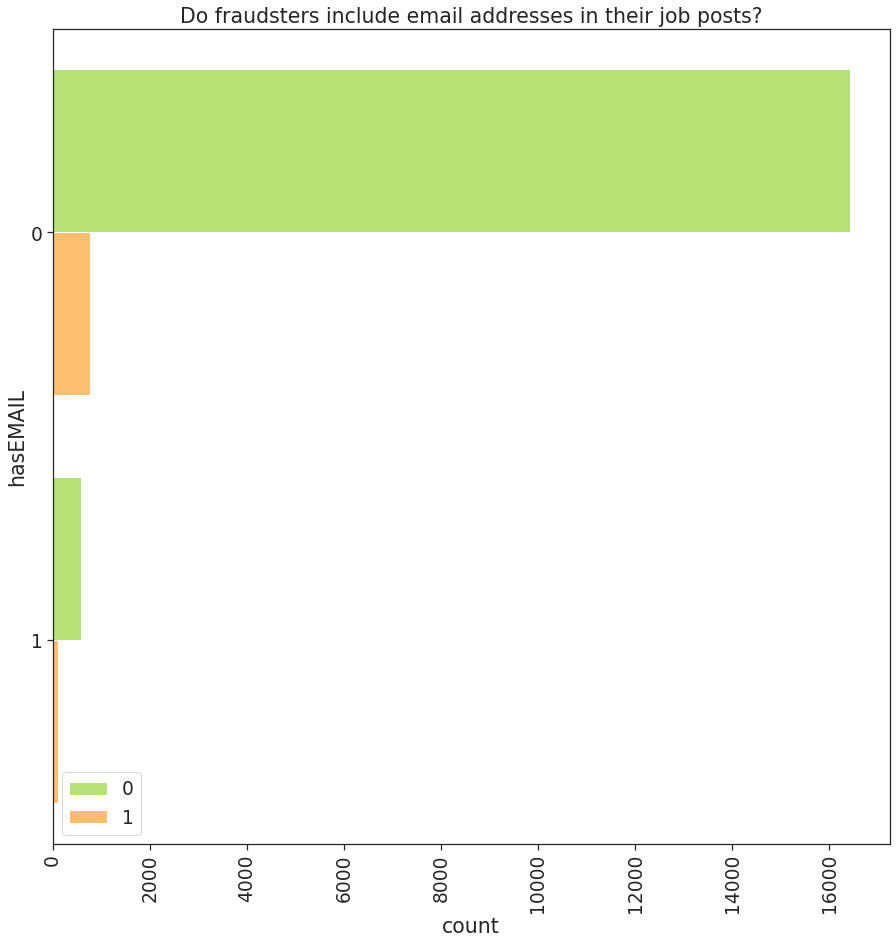

In [10]:
sns.countplot(y='hasEMAIL', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

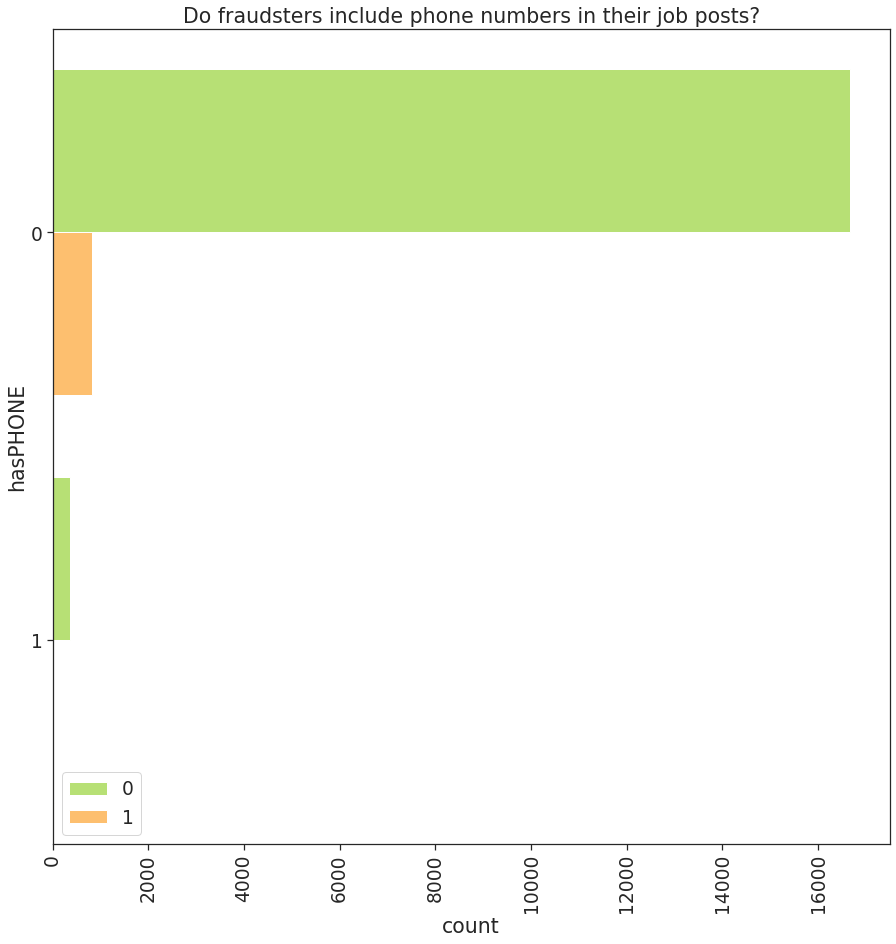

In [11]:
sns.countplot(y='hasPHONE', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

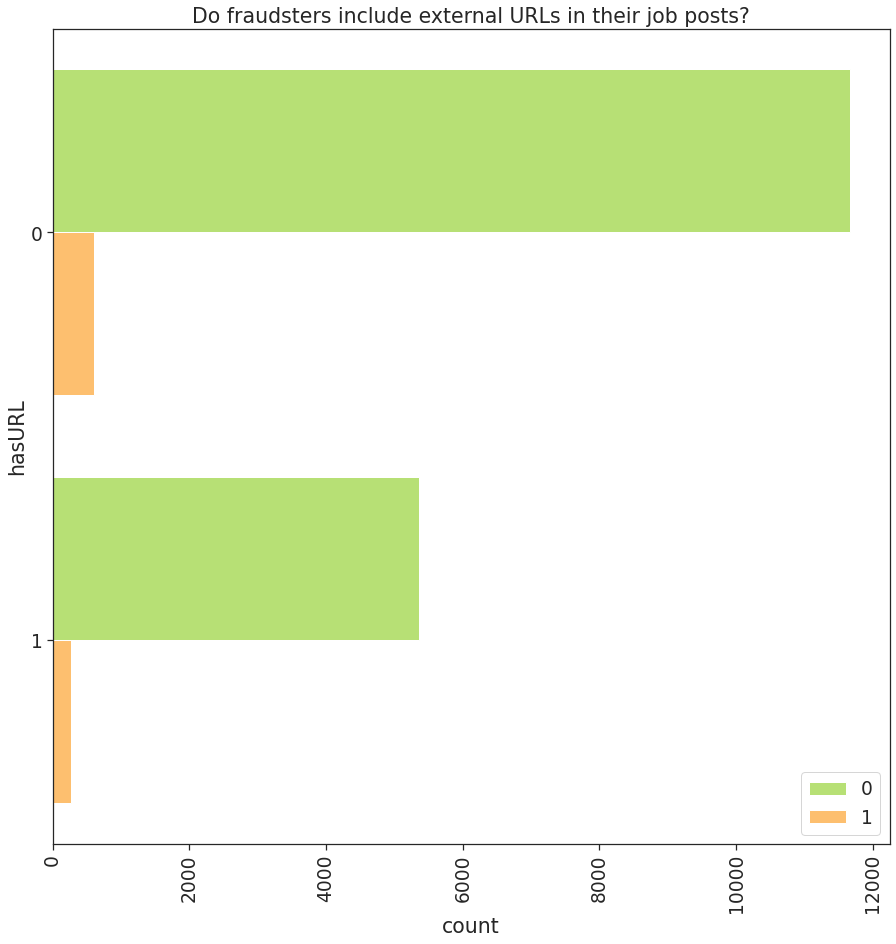

In [12]:
sns.countplot(y='hasURL', hue='fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

# Conclusion

Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:

* they tend to be lacking more information than the legitimate job offers but fraudsters will make an effort for informations such as location, department, function and especially salary_range.
* when information is provided, it will tend to be shorter, the text is going to be more succinct. This is especially true for the company profile and the job requirements.

In terms of content, fraudulent posts will:

* target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational were not specifically targeted, some even not targeted at all (in this dataset at least)
* mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but proportionally less than any other type of positions and temporary contracts were not targeted at all (in this dataset at least)
* target all type of experience but mainly entry level positions. Once again Associates are less exposed and Directors, Executive and Mid-Senior levels are a little less exposed too.
* tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but as phone, emails and urls have been anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding about fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.